# <font color="#ebb73d" face="Comic Sans MS">Content - Notebook part 2</font> 

- Part 4: [Model Training](#9)
  - Part 4.1: [Baseline Model](#10)
    - Part 4.1.1 [Build Generators](#11)
    - Part 4.1.2 [Build Discriminators](#12)
    - Part 4.1.3 [Build CycleGAN Model](#13)
    - Part 4.1.4 [Define Loss Functions](#14)
    - Part 4.1.5 [CycleGAN Training](#15)
  - Part 4.2: [Model Tuning 1](#16)
  - Part 4.3: [Model Tuning 2](#17)
  - Part 4.4: [Model Tuning 3](#18)
- Part 5: [Submit Results](#19)
- Part 6: [Conclusions](#20)
- [References](#21)



## <font face="Comic Sans MS" color=#ad2004 >Kaggle won't allow me to have notebook with large than 1MB, this notebook has 2 parts. This is the second part and the first part is [here](https://www.kaggle.com/code/jieshends2020/gan-painting-part-1)</font>

# <a id="9"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 4: Model Training 🧙‍♀️</h1>

</div>

First, some essential codes from my [part 1](https://www.kaggle.com/code/jieshends2020/gan-painting-part-1) of this project. Part 1 has more of detailed explanation of each steps if you are interested to know.

## <font color= #d59a41 face="Comic Sans MS"> Import Files</font>

In [ ]:
# Install packages
!pip install seaborn
!pip install pyarrow
!pip install tensorflow

In [ ]:
# Import packages
import os, cv2, re,logging,  warnings, functools, PIL, shutil
from kaggle_datasets import KaggleDatasets
import numpy as np 
import pandas as pd
import random
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy

print("TensorFlow version:", tf.__version__)

## <font color= #d59a41 face="Comic Sans MS"> TPU Config</font>

In [ ]:
#TPU configuration
try:
    # detect the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # print TPU master if sucessful
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    print('ALERT: Not connected to a TPU runtime')
    tpu = None

if tpu:
    # TPU initialization 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # TPU instantiation 
    strategy = tf.distribute.TPUStrategy(tpu)

else:
    # Retrieve the default distribution strategy in TensorFlow when TPUs are not available
    strategy = tf.distribute.get_strategy()

# determine the number of replicas/workers
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
# set up AUTOTUNE to optimize data pipeline performance dynamically
AUTO= tf.data.experimental.AUTOTUNE

## <font color= #d59a41 face="Comic Sans MS"> TFRecord Files</font>

In [ ]:
# get Monet and Phote image filename paths
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')


In [ ]:
# decode and normailization function 

def decode_and_rescale(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # Just to enforce all image to be consistent shape (256*256*3) although mostly likely they are
    image = tf.reshape(image, [*[256,256], 3]) 
    return image

# read TFRecord function - parse and then decode
def read_tfrecord(example): 
    '''
    Input: 
    - example: This is a single serialized example from a TFRecord file. Each example typically contains features stored as serialized tensors.
    ''' 
    # tfrecord_format: This dictionary defines the expected features and their types in the serialized example. 
    # Each feature is specified with its name and a tf.io.FixedLenFeature indicating the expected shape and data type.
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    # parses the serialized example using the provided format specification. 
    # It decodes the serialized features into their corresponding tensors according to the specified format.
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_and_rescale(example['image'])
    return image

## <font color= #d59a41 face="Comic Sans MS"> Image Augmentations and Data Loading</font>

In [ ]:
def image_rotation(image):
    try:
        # Define rotation angles
        rotation_angles = tf.constant([0, 1, 2, 3], dtype=tf.int32)  # 0, 90, 180, 270 degrees
        
        # Shuffle rotation angles and choose one randomly
        shuffled_angles = tf.random.shuffle(rotation_angles)
        rotation_angle = shuffled_angles[0]
        
        # Rotate based on the randomly chosen rotation angle
        image = tf.image.rot90(image, k=rotation_angle)
    except Exception as e:
        print("Error in image rotation:", e)
    return image

def image_flip(image):
    try:
        return tf.image.random_flip_left_right(tf.image.random_flip_up_down(image))
    except Exception as e:
        print("Error in image flip:", e)
        return image

def image_transpose(image):
    try:
        return tf.image.transpose(image)
    except Exception as e:
        print("Error in image transpose:", e)
        return image

def image_crop(image, height=256, width=256):
    try:
        return tf.image.random_crop(image, size=[height, width, 3])
    except Exception as e:
        print("Error in image crop:", e)
        return image


In [ ]:
# Let's load data!
# load data function

def load_dataset(filenames, labeled=True, ordered=False,repeat=False, shuffle=False,rotation=False, flip=False, transpose=False, crop=False, height=256,width=256):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    
    if repeat:
        dataset = dataset.repeat()
   
    if shuffle:
        dataset = dataset.shuffle(512)
    if rotation:
        dataset = dataset.map(image_rotation, num_parallel_calls=AUTO)
    if flip:
        dataset = dataset.map(image_flip, num_parallel_calls=AUTO)
    if transpose:
        dataset = dataset.map(image_transpose, num_parallel_calls=AUTO)
    if crop:
        # Use functools.partial to create a function with preset height and width arguments
        crop_function = functools.partial(image_crop, height=height, width=width)
        dataset = dataset.map(crop_function, num_parallel_calls=AUTO)
    
    # Add prefetching
    dataset = dataset.prefetch(AUTO)

    return dataset

BATCH_SIZE=1
# Monet
monet_data = load_dataset(MONET_FILENAMES, labeled=True).batch(batch_size=1)
# Photo
photo_data = load_dataset(PHOTO_FILENAMES, labeled=True).batch(batch_size=1)

## <a id="10"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 4.1: Baseline Model</h2>
</div>

As a beginner, I find it's hard (out of my mind indeed) to implement CycleGAN just based on paper and theories or figure a great model structure. As always, I find the fastest way to learn is to see how others do on Kaggle during my own problem solving process. For example, this [notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial) really helpful. Also,[Keras](https://keras.io/examples/generative/cyclegan/) and [Tensorflow](https://www.tensorflow.org/tutorials/generative/cyclegan) documents may be worth to check out too. So, the "disclaimer"" is that lots of model structure or codes below for my first baseline model would be inspired or primarily use those, but of course adjusted/digested by my own understandings. 

#### <a id="11"></a>
<div style="text-align: center; background-color: #d59a41 ; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;color: #075674;">
    <h2> Part 4.1.1: Build Generators </h2>
</div>

## My Plan to Build the Generator and the Reasonings

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black;">
    
    
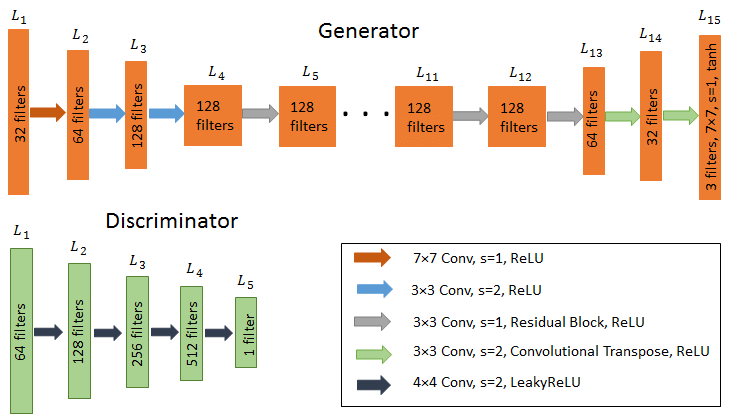<br>
(Image from [this article](https://www.researchgate.net/figure/Architecture-of-the-generator-and-discriminator-of-unpaired-CycleGAN-Conv-2D_fig3_343075688) )


As discussed in CycleGANs, we will build 2 generators (G to input Photo images to generate Monet style images, F to input Monet painting images to generate Photo images). However, building generators involves a few sub-structures and some essential details. Below are my plan to build them and the reasonings.
    
## <font color="#075674" face="Comic Sans MS"> Downsample Stacks (Encoders) in CycleGAN Generator</font>
- We'll add several downsampling blocks. They are used to increase the network's capacity to **extract higher-level features** from the input image. To do this, we'll increase the number of channels while reducing the spatial dimensions. The primary goal is to capture global information and abstract representations of the input image.
- Those downsampling blocks will be used in the **encoding** part of the **CycleGAN generators** to **extract higher-level features** from the input image (such as  global information and abstract representations of the input image).
- For implementation, we will use filters and strides to reduce feature maps by factor of 2 each block until we get our desired dimension for our latent representation feature. The chanels will gradually increase too (by factor of 2 as a good practice) but it will stop increase and stay at a certain number of channel.

## <font color="#075674" face="Comic Sans MS"> Upsample Stacks (Decoders) in CycleGAN Generator</font>
- We'll add several upsampling blocks to **increase the spatial resolution** of feature maps. 
- Those upsampling blocks will be used in the **decoding** part of the **CycleGAN generators**. The purpose is to **reconstruct high-resolution images** from the low-resolution feature representations learned in the encoder.
- For implementation, encoders and decoders usually have symmetric shape. So, we will sort of have a similar but reverse kind of upsampling structure and we'll use **Transposed convolution** layers instead of convolution layers.

## <font color="#075674" face="Comic Sans MS"> Skip Connections in CycleGAN Generator</font>
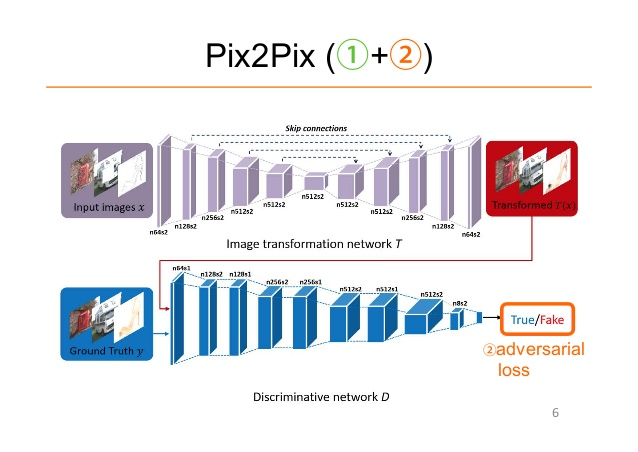 <br>
(Image from [this article](https://blog.paperspace.com/unpaired-image-to-image-translation-with-cyclegan/)) <br>
- We'll add skip connections. Skip connections are also used in famous ResNets. They are very helpful to retain information in deep network. When a connection is added from some earlier layer feature map, the information from that earlier layer, which might be otherwise lost could be retained. I think [this video](https://www.youtube.com/watch?v=RYth6EbBUqM) explains the reason very well. For implementation, we will add skip connection in a symmetric way (similar as the image above). That is, adding the feature map from corresponding downsampling block to the upsampling block to retain the information we got in downsampling blocks. 
 

## <font color="#075674" face="Comic Sans MS">Other Implementation Details</font>
- We'll use **Transposed convolution** layers instead of our typical convoluation layers in **upsampling**. Tranposed convoluation is basically the opposite of Convoluation. That is, instead of reducing the spatial dimensions of the input, it enlarges them. For more details, check out [this article](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0). 
- We'll use transposed convolution to upsample the input tensor to the desired output dimensions in the last output layer. For activation function, since we want the output pixel values to be in the range [-1, 1], we will uses a **tanh**.
    
- **Use Stride**:
  - We'll use strides to reduce feature maps spacial dimensions in downsampling. Stride is commonly used in CycleGAN downsampling. Another common way to do downsampling in CNN is to use **maxpooling** (or other poolings). However it seems maxpooling is not typically preferred for downsampling in CycleGANs. In [DCGAN paper](https://arxiv.org/abs/1511.06434), pooling layers are replaced by stride convolutions **"to allow the network to learn its own spatical downsampling"**. I guess this applies to CycleGAN too. As for any model structures, stride and maxpooling have their pros and cons. [This discussion](https://stats.stackexchange.com/questions/387482/pooling-vs-stride-for-downsampling) may help us understand this better. From my own understanding, I feel the reason stride could help the network to learn its own spatical downsampling here is because **stride is learnable**. That is, stride allows the network to adaptively learn the downsampling patterns from the data. In contract, maxpooling is fixed (or not learnable). It always only selects the maximum value (and discard the non-maximal values) from a pooling window. This method may lead to loss of detailed information, which is crucial to CycleGAN generator.
  - Just like downsampling helps the network capture larger receptive fields and extract high-level features, **upsampling with strides** can help the network enlarge its receptive field in the input space. This is particularly important in tasks like image translation where the network needs to understand the context of the input image and generate high-resolution outputs. 
  - Thus, I will start by using a stride of 2 for both upsampling and downsampling, which basically reduce the image size by factor of 2. This is also a common practice for CycleGAN. This way, the convolution operation would skips only every other pixels at a time (instead of too much too soon). 
  
- **Use Padding**: 
    - We'll use padding to help preserve informations in the sides and edges. When performing downsampling and upsampling, the sides and corners of the image don't get the same 'treatment' as other area pixels. Paddint is to help to fill in those missing pixels with their neighboring pixels.
    - We'll use "same" padding for both downsampling and upsampling to simplify. This way, image size would be easily reduce by factor or stride size (so we don't need to try hard to figure what the output dimension of feature maps would be). For example, if we use stride of 2, if we use "same" padding in each downsampling, the feature maps would be reduced by half (and vice versa for upsampling).
 
- **Use Instance Normalization**: 
  - We'll use instant normalization (IN) instead of batch normalization (BN). To see more details, [this paper](https://arxiv.org/abs/1607.08022) shows how a simple change from BN to IN could results in better image with relative fast training time. My understanding after reading it:
    - IN normalizes each sample independently (instead of across samples like batch normalizaation does) based on its own mean and standard deviation. Also, this makes it less affected by variations in batch statistics, which may help to mitigate internal covariate shift and provide more stable normalization and faster convergence. As a result, from paper, IN allows to "remove instance-specific contrast information from the content image, which simplifies generation." As a practical results, the image improved and it is fast.   
    - IN is kept at testing time instead of "freeze and simplify them out as done for batch normalization" (per paper). This improved the images too.

  - So, we will use IN for both downsampling (maybe not for the first layer since it's still getting lower level features and it could be good to retain more of the original information) and updsampling. We will start by initializing it useing "stddev=0.02", which is a common practice to do.
- **Use LeakyReLU**: We'll use LeakyReLU instead of the normal ReLU. For negative inputs, leackyReLU gives a small gradient (instead of zero like traditional ReLU). This small negative slope helps prevent neurons from become inactive and stop learning due to negative inputs. In CycleGAN, where the network needs to handle a wide range of input distributions, Leaky ReLU can help maintain gradient flow and prevent saturation of the network. 

- **Use Dropout layer(s)**:  We'll add dropout layers in upsampling. In upsampling, the network is reconstructing higher-level features from lower-resolution representations. These higher-level features often contain more complex patterns and details compared to the lower-level features extracted in downsampling layers. Dropout may help prevent the model from memorizing noise or irrelevant details in these complex features, thereby improving its generalization ability and prevent overfitting. We mind also use dropout layers in upsampling but it's optional. 

- **Not Use Bias Term**: We won't have bias terms in generators (or in discrimiators). I am not 100% sure, but per [this discussion](https://stats.stackexchange.com/questions/482305/batch-normalization-and-the-need-for-bias-in-neural-networks), bias terms are usually not needed when we use normalization. I think it makes sense since normalization will "center" the data anyway. 

## <font color="#ebb73d" face="Comic Sans MS"> Downsample</font>

Now let's build the downsample block. The details of how and why I want to build the downsampling this way we've already discussed. Just a reminder, each downsample block will have
- 1. A convolution layer with stride and padding
- 2. An optional instance normalization layer
- 3. A LeakyReLU layer.

I set up the code below in a way that we can easily tune those parameters during training. 
- filters: filter size
- size: number of channels
- stride: stride number (the width)
- padding: padding type 
- apply_instancenorm: whether to apply instance normalilzation. If "False", none normalization would be applied.

In [ ]:
# Downsample function block
def downsample(filters, size, stride=2,padding='same', apply_instancenorm=True ):            
    initializer = tf.random_normal_initializer(0., 0.02) # Initialize weights on filters
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02) # Initialize instance Normalization

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, 
                             strides=stride, 
                             padding=padding,
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_instancenorm: 
        result.add(tf.keras.layers.GroupNormalization(groups=-1,gamma_initializer=gamma_init ))  # GroupNormailization for instance normalization
    result.add(layers.LeakyReLU())

    return result

## <font color="#ebb73d" face="Comic Sans MS"> Upsample</font>

Now let's build upsample block. The details of how and why I want to build the updampling this way we've already discussed. Just a reminder, each upsample layer will have
- 1. A transpose convolution layer with stride and padding. 
- 2. An instance normalization layer
- 3. An optional dropout layer
- 4. A LeakyReLU layer.

I set up the code below in a way that we can easily tune those parameters during training:
- filters: filter size
- size: number of channels
- stride: stride number (the width)
- padding: padding type 
- apply_dropout: whether to apply droppout. If "False", none dropout would be applied.
- dropout_rate: If want dropout layers, can set up teh dropout rate. 

In [ ]:
# Upsample function block
def upsample(filters, size, stride=2,padding='same',apply_dropout=False, dropout_rate = 0.5):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, 
                                      strides=stride,
                                      padding=padding,
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(groups=-1,gamma_initializer=gamma_init )) # GroupNormailization work the same as deprecated InstanceNormalization()
    if apply_dropout:
        result.add(layers.Dropout(dropout_rate))

    result.add(layers.ReLU())

    return result

## <font color="#ebb73d" face="Comic Sans MS"> Build Generator </font>

Now let's build the generator. The details of how and why I want to build the generator this way we've already discussed. Just a reminder:
- 1. We will start with an input image of size (256,256,3). In training, it will be Monet or photo image sending to it.
- 2. For the encoder, we will have a series of downsample blocks. For the first four blocks, the channel numbers will double in each block. Then for "transfer blocks", which we can decide how many transfer blocks to have, the channel numbers will stay the same. The  The size of the feature maps decreases by half with each downsample operation.
- 3. For the decoder, the structure is symmetric to encoder. Additionally, as discussed, we'll have skip connections added. Corresponding upsampling feature map skip connection will be added to each downsampling block to retain the correcpsonding feature map features.
- 4. For the output layer, we will have a transpose convolution layer with tanh activation.

I set up the code below in a way that we can easily tune those parameters during training:
- dropout_rate: can set up teh dropout rate. 
- filter_size_E1: the 1st layer filter size. It can have different size than other layers. In some papers, people use a differernt filter size for the 1st layer.
- filter_size: fitler size for layers other than the 1st layer. 
- filter_chanel_1st: chanel numbers for the 1st layer. As discussed, the channel number will be doulbe for the first four layers in encoding. So, if the 1st layer chanel number is 64. The next four layers chanel numbers will be 128, 256, 512 and stay at 512 in the transfer layers.
- transfer_layers: number of transfer layers we want. Those layers (*2) will be added in between encoding and decoidng. 
- stride_num: stride number (the width)
- padding_style: padding type 


In [ ]:
# Build Generator
def Generator(dropout_rate=0.5, filter_size_E1=4, filter_size=4, filter_chanel_1st=64, transfer_layers=5, stride_num=2, padding_style='same'):
    inputs = layers.Input(shape=[256,256,3])

    # encoder
    encoder = [
        downsample(filters=filter_chanel_1st, size=filter_size_E1,  stride=stride_num,  padding=padding_style,apply_instancenorm=False),# (bs, 128, 128, 64)， 
        downsample(filters=filter_chanel_1st*2, size=filter_size,  stride=stride_num, padding=padding_style), # (bs, 64, 64, 128)
        downsample(filters=filter_chanel_1st*2**2, size=filter_size,  stride=stride_num,padding=padding_style), # (bs, 32, 32, 256)
    ]
    encoder += [
        downsample(filters=filter_chanel_1st*2**2,size=filter_size, stride=stride_num,padding=padding_style)  # (bs, 16, 16, 512) -> (bs, 8, 8, 512)->(bs, 4, 4, 512)->(bs, 2, 2, 512)
        for _ in range(transfer_layers)
    ]
    
   
    # decoder
    decoder = []
    decoder += [
        upsample(filters=filter_chanel_1st*2**2, size=filter_size, stride=stride_num ,padding=padding_style, apply_dropout=True, dropout_rate=dropout_rate)  # (bs, 2, 2, 512)->(bs, 4, 4, 512)->(bs, 8, 8, 512)
        for _ in range(transfer_layers-1)
    ] 

    decoder.extend([
        upsample(filters=filter_chanel_1st*2**2, size=filter_size,  stride=stride_num,padding=padding_style),  # (bs, 16, 16, 512)
        upsample(filters=filter_chanel_1st*2*2, size=filter_size, stride=stride_num,padding=padding_style),  # (bs, 32, 32, 256)
        upsample(filters=filter_chanel_1st*2, size=filter_size, stride=stride_num,padding=padding_style),  # (bs, 64, 64, 128)
        upsample(filters=filter_chanel_1st, size=filter_size, stride=stride_num,padding=padding_style)    # (bs, 128, 128, 64)
    ])

    initializer = tf.random_normal_initializer(0., 0.02) #initializer for last output layer
    
    last = layers.Conv2DTranspose(3, filter_size_E1,            #3 is output channel, which is our RGB color channel
                                  strides=stride_num,
                                  padding=padding_style,
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    
    x = inputs
    # Downsampling through the model
    # x will be sequentially passed through the layers of the encoder.
    # Intermediate feature maps will be stored in the skips list for later use in skip connections.
    skips = []
    for down in encoder:
        x = down(x)
        skips.append(x)
        
    #since decoder has symmetric shape of encoder, need to reverse the order of feature maps from encoder.
    skips = reversed(skips[:-1]) 

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip]) # For each upsampling block, skip connection from "mirroring" downsampling feature map will be added 

    x =  last(x)
    model = keras.Model(inputs=inputs, outputs=x)


    # Print model summary
    return model

## <font color="#ebb73d" face="Comic Sans MS">  Generator Results</font>

strategy.scope() is typically used in TensorFlow code when working with distributed training using the tf.distribute.Strategy API. This context manager is used to specify the scope of operations that should be distributed across multiple devices or accelerators (e.g., GPUs or TPUs).

In [ ]:
# Now, let's take a look what generator can get us!
# Use strategy.scope to create generators


with strategy.scope():
    monet_generator = Generator(dropout_rate=0.5, filter_size=4, filter_chanel_1st=64, transfer_layers=5, stride_num=2, padding_style='same')
    photo_generator= Generator(dropout_rate=0.5, filter_size=4, filter_chanel_1st=64, transfer_layers=5, stride_num=2, padding_style='same')
# print("Generator Model Summary\n", monet_generator.summary())
# Generate images    
example_photo = next(iter(photo_data))
photo_to_monet = monet_generator(example_photo)

example_monet = next(iter(monet_data))
monet_to_photo = photo_generator(example_monet)

# Plot
plt.figure(figsize=(15, 2))  
plt.subplot(1, 4, 1)
plt.title("Original Photo Image")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 4, 2)
plt.title("Generator G: Monet style Image from Photo")
plt.imshow(photo_to_monet[0] * 0.5 + 0.5)


plt.subplot(1, 4, 3)
plt.title("Original Monet Image")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 4, 4)
plt.title("Generator F: Photo from Monet Painting")
plt.imshow(monet_to_photo[0] * 0.5 + 0.5)
plt.show()

- As discussed, the generators first won't know what to generate. So, they just output blank ones. 

#### <a id="12"></a>
<div style="text-align: center; background-color: #d59a41 ; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;color: #075674;">
    <h2> Part 4.1.2: Build Discriminators </h2>
</div>

## My Plan to Build the Discriminator and the Reasonings

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">

As discussed in CycleGANs, we will build 2 discriminators (Dy to judge Monet style images generated from Photos, Dx to judge Photo images generated from Monet paintings). As for generatosr, there are a few sub-structures and some essential details. Below are my plan to build them and the reasonings.
    

## <font color="#075674" face="Comic Sans MS">Add downsampling blocks</font>

- We'll add downsampling blocks. Discriminators are a little like encoders in generator, which needs to extract image information by reducing the spatial dimensions from the input images. So, we'll first have some similar downsampling blocks (but probably less in numbers) just like encoder in generator. It won't reduce the feature map to very small dimension like encoder does though. Discriminator's job is more like image classification task (capture local and global features). So, we will retain some dimension of feature map. For example, 32 * 32.
    
## <font color="#075674" face="Comic Sans MS">Add Convolution layers</font>
-  We'll add convolution layers after downsampling blocks in our discriminators. At some point, we don't want to loss the spatical dimesnion further (as downsampling layers provide) when extracting/learning features. My personal understanding is that it's similar to how we use convolution layers in image classifiers, we sometimes want to learn by keeping some dimensions to learn increasingly complex features from the input images.

    
## <font color="#075674" face="Comic Sans MS">Add Zero Padding layers</font>
    
- We'll add zero padding layer right before each covolution layers in discriminator.  Per [Keras documentation](https://keras.io/api/layers/reshaping_layers/zero_padding2d/), zero padding layer will "add rows and columns of zeros at the top, bottom, left and right side of an image tensor". Zero-padding is often added before applying convolutional operations to help the borders of the input receive the same treatment as other regions during convolution operations. The discriminator's job isn't as simple as classify cats or dogs, it's important to the exam every part of the image to make sure if resemble the style image.  

## <font color="#075674" face="Comic Sans MS"> Output layer of Discriminator</font>
-  We'll have a convolution layer that output a lower-dimensional  n * n feature map (where n is much smaller than our input image 256 * 256 but we in codind) for our discriminator output layer.  Each element in this feature map represents a spatial region of the input image and its corresponding features learned by the discriminator. So, this n * n abstract representations of the input image helps the discriminator in making its final classification decision. 
    
## <font color="#075674" face="Comic Sans MS">Other Implementation Details</font>
- We'll add instance Normalization, LeakyReLUSimilar for discriminator as well. The reasons are similar for generator (which we've discussed in generator section)
- We'll added a (Gaussian) noise layer for input. From my training, it seems discriminator seriously tends to overfit quickly. I hope this would help with the overfitting of discriminator.

Below is my discriminator code. I set up the code below in a way that we can easily tune those parameters during training:

- filter_size: fitler size for layers.
- filter_chanel_1st: chanel numbers for the 1st layer. Similar to Generator, the channel number will be doule after each downsampling block until zero padding layer. So, if we have 3 downsampling layers and the 1st downsampling layer chanel number is 64. The next two layers chanel numbers will be 128, 256.
- down_layer_num: number of downsampling blocks in discriminator
- strides: stride number (the width)


In [ ]:
# Discriminator
def Discriminator(filter_size=4, filter_chanel_1st=64, down_layer_num=3, strides=1):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    # Add noise layer. Hope to prevent discriminator to overfit
    noise = layers.GaussianNoise(0.001)(inp)  # Add Gaussian noise with standard deviation 
    x = layers.Concatenate()([x, noise])

    down_layers = []
    
    for i in range(down_layer_num):
        filters = filter_chanel_1st * (2 ** i)
        if i==0:
            down_layers.append(downsample(filters, filter_size, apply_instancenorm=False)) # no normalization on first layer of discriminator
        else:   
            down_layers.append(downsample(filters, filter_size)) #feature maps after each down layer: (bs, 128, 128, 64)->(bs, 64, 64, 128)->(bs, 32, 32, 256) if 3 layers

    # Applying downsampling layers
    for down in down_layers:
        x = down(x)

    zero_pad = layers.ZeroPadding2D()(x)  # Zero padding before the final convolutional layer
    conv = layers.Conv2D( filter_chanel_1st *  (2** (down_layer_num)), filter_size, strides=strides, kernel_initializer=initializer, use_bias=False)(zero_pad) #(x,x,x,512) if 3 down layers
    norm = tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # zero padding before the output layer
    last = layers.Conv2D(1, filter_size, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)


#### <a id="13"></a>
<div style="text-align: center; background-color: #d59a41 ; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;color: #075674;">
    <h2> Part 4.1.3: Build CycleGAN Model </h2>
</div>

## How I will build my CycleGAN and why. 


<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black">
    
We'll build mostly typical CycleGAN structure. How to build a typical CycleGAN and why are discussed in [part 1](https://www.kaggle.com/code/jieshends2020/gan-painting-part-1) of this notebook. A quick recap:
- We will have 2 generators G and F to generate Monet and photo images, and 2 discriminators Dy and Dx to discriminate generated monet and photo images. 
- For loss functions, we will have the following:
    - Adversal losses for eqch discriminator: Those are basically [binary cross-entropy](https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d) for both real and fake images. We'll have one adversal loss for monet generator G and one for photo generator F.
    - Adversal losses for each generator: this is the opposite of the fake image part of discriminator adversal loss because discriminator want the discriminator to think the fake image is real while discriminator want to correctly classify the fake images when they are sent to it.  We'll have one adversal loss for monet discriminator and one for photo discriminator.
    - Cycle consistency losses only for generators. This is completly different from binary cross entropy, this a type of L1-norm reconstruction loss. This part ensures that the translated images maintain their original content when mapped back to their original domain. WE'll have just one cycle consistency consistent of both Monet generator G and photo generator F (as opposed to seperate ones for G and F like adversal losses).
- We will have a term (lamda) to control the importance of those 2 kinds of losses. <br>
    
A few additional notes for our particular CycleGAN model below:
- **Identity losses**: The original CycleGAN paper doesn't have this piece. For our model, we will add this. What is identity loss? For example, our generator G is to generate monet photos. So, usually we expect real photos to be sent to G. But what if we sent a monet photo to G to generate "another" monet photo? - We hope the generated monet photo to look like the original one we sent to G. That is, we want G(y) $\approx$ y. And, simlarily G(x) $\approx$ x. But wait, in CycleGAN, don't we only send images from one domain to generators to generate images from another domain? Why should we worry about "identity loss"? Here, **identiy loss acts as a regularization term that helps to prevent unnecessary transformations on images that are already in the desired domain**. This regularization can be especially **helpful in scenarios where the generator might overfit or unnecessarily distort images that are already similar to the target domain**.

Below, we will create a class of a CycleGAN model, which define compile elements and training steps:
- At the beginning of each training step, one pair of real images (one batch size of photo and one batch size of monet image) are sent for training.
- A forward pass in training: generators generate images and discriminators discriminate.
- A backward pass in training: loss calculations, gradient computations, and parameter updates for generators and discriminators 
- At the end, the losses of genearaters and discriminators will be returned.

Note there are some code for buffer, which I tried to set up so that we can update discriminator based on a fixed numbers (buffer-size) of previous images instead of just on the images in the last batch. This is in the original paper to generalize and I think it probably would help with the problems of discriminator overfitting so quickly and dicriminator overwhelming the generator. However, I had some implementing issues. I comment them out so I may be able to get back to it at a later time.

In [ ]:
class CycleGan(keras.Model): #the CycleGan class is inheriting from the keras.Model class, making keras.Model the parent class of CycleGan.
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        buffer_size=50,

    ):
        super(CycleGan, self).__init__() # Initializes the superclass of CycleGan, which is keras.Model.
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.buffer_size = buffer_size

#         self.real_monet_buffered = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
#         self.real_photo_buffered = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
#         self.fake_monet_buffered =  tf.zeros((0, 256, 256, 3), dtype=tf.float32)
#         self.fake_photo_buffered =  tf.zeros((0, 256, 256, 3), dtype=tf.float32)
    
    # define optimizers and losses in compiling
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,

    ):
        super(CycleGan, self).compile() #calls the compile method of parent class 
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        # Use TensorFlow context manager (an object that is used with the "with...as..." statement) tf.GradientTape that records operations for automatic differentiation
        with tf.GradientTape(persistent=True) as tape:
            #########################################################################
            ##                       Forward Pass                                  ##
            #########################################################################
            
            ################################
            ## generators generate images ##
            ################################
            # Generate fake and cycled images: photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # Generate fake cycled images: monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generate same domain to itself 
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            #######################################
            ## Discriminator discriminate images ##
            #######################################
            # Save images to buffer for discriminators
#             self.real_monet_buffered = tf.concat([self.real_monet_buffered, real_monet], axis=0)
#             self.real_photo_buffered = tf.concat([self.real_photo_buffered, real_photo], axis=0)
#             self.fake_monet_buffered = tf.concat([self.fake_monet_buffered, fake_monet], axis=0)
#             self.fake_photo_buffered = tf.concat([self.fake_photo_buffered, fake_monet], axis=0)
            # Ensure the buffer size doesn't exceed the maximum buffer size
#             @tf.function
#             def get_buffer_size(tensor):
#                 return tf.shape(tensor)[0]

#             current_buffer_size = get_buffer_size(self.real_monet_buffered)
#             current_buffer_size_scaler = current_buffer_size.numpy()
#             if current_buffer_size_scaler> self.buffer_size:
#                 excess_elements = current_buffer_size - self.buffer_size
#                 self.real_monet_buffered = self.real_monet_buffered[excess_elements:]
#                 self.real_photo_buffered = self.real_photo_buffered[excess_elements:]
#                 self.fake_monet_buffered = self.fake_monet_buffered[excess_elements:]
#                 self.fake_photo_buffered = self.fake_photo_buffered[excess_elements:]

            # Send real images to discriminators
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo= self.p_disc(real_photo, training=True)
#             disc_real_monet_buffered = self.m_disc(self.real_monet_buffered, training=True)
#             disc_real_photo_buffered = self.p_disc(self.real_photo_buffered, training=True)

            # Send fake images to discriminators
            disc_fake_monet= self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
#             disc_fake_monet_buffered = self.m_disc(self.fake_monet_buffered, training=True)
#             disc_fake_photo_buffered = self.p_disc(self.fake_photo_buffered, training=True)

            
            ###################################################################################
            ##                                   Backward Pass                               ##
            ###################################################################################
            
            #######################
            ##      Losses       ##
            #######################
            # Geneartor Adversary loss:  generators will send all fake photos to discriminator and want to discriminator to think they are real
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            #  Generator Cycle consistency losses: only for generators, generators want to generate cycled photos look like the original photo 
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator losss, identity losses are added to prevent overfitting
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # Discriminators losses - they only have avdersary losses, Calculate discriminator loss using both real and fake images from the buffer
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss= self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        ##############################
        ##    Update Gradients      ##
        ##############################
            
        # generator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
            
        # Discrimator gradients
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients= tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        
        ##############################
        ##    Update Parameters     ##
        ##############################

        # generator parameters
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,  self.p_gen.trainable_variables))

         # Discriminator parameters
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))


        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "total_cycle_loss": total_cycle_loss
        }

#### <a id="14"></a>
<div style="text-align: center; background-color: #d59a41 ; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;color: #075674;">
    <h2> Part 4.1.4: Define Loss Functions </h2>
</div>

## <font color= #d59a41 face="Comic Sans MS"> Discriminators Adversary Losses</font>

As discussed, discriminators will only have adversary losses. (For complete loss functions and explanations, see [part 1](https://www.kaggle.com/code/jieshends2020/gan-painting-part-1) of this notebook):
- When real images send to discriminators, we want discriminators to think them as "ones_like" (real).
- When fake images send to discriminators, we want discriminators to think them as "zeros_like" (fake).
Implementation details:
- Loss function will be applied to the logits (no activation). It's a common practice in CycleGAN. 
- Loss will be computed the  separately for each sample.(so, "reduction=tf.keras.losses.Reduction.NONE")


In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5 #return the avg

## <font color= #d59a41 face="Comic Sans MS"> Generators Adversary Losses</font>



Generators will send fake generated images to discriminator and want the discriminators to think them as "ones_like" (real). 

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

## <font color= #d59a41 face="Comic Sans MS"> Generators Cycle Consistency Losses</font>

We'll want the cycle consistency loss, which is L1-norm reconstruction cost betweeb real and cycled images to be small. lambda is to control the importance of this part.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

## <font color= #d59a41 face="Comic Sans MS"> Generators Identity Consistency Losses</font>

Lastly, the identity loss will be L1-norm reconstruction cost betweeb real and generated image to be the same domain from the real image. We want to keep it small to prevent model from overfitting.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### <a id="15"></a>
<div style="text-align: center; background-color: #d59a41 ; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;color: #075674;">
    <h2> Part 4.1.5: CycleGAN Training </h2>
</div>

We've constructed all the necessary parts for training. Now, we are ready to train the model. 

## <font color= #d59a41 face="Comic Sans MS"> Plot Helper Functions</font>

In [ ]:
# Plot functions

# plot adversary, cycle losses
def plot_losses(history):
    # Calculate mean losses
    mean_monet_gen_loss = np.mean(history['monet_gen_loss'], axis=(1, 2, 3))
    mean_photo_gen_loss = np.mean(history['photo_gen_loss'], axis=(1, 2, 3))
    mean_monet_disc_loss = np.mean(history['monet_disc_loss'], axis=(1, 2, 3))
    mean_photo_disc_loss = np.mean(history['photo_disc_loss'], axis=(1, 2, 3))


    # Plotting the losses
    epochs = range(1, len(mean_monet_gen_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, mean_monet_gen_loss, 'b', label='Monet Gen Loss')
    plt.plot(epochs, mean_photo_gen_loss, 'r', label='Photo Gen Loss')
    plt.plot(epochs, mean_monet_disc_loss, 'g', label='Monet Disc Loss')
    plt.plot(epochs, mean_photo_disc_loss, 'y', label='Photo Disc Loss')
    plt.plot(epochs, history['total_cycle_loss'], 'm', label='Cycle Loss')  # Added total cycle loss
    plt.title('CycleGAN Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Loss')
    plt.legend(loc='upper right')
    plt.show()
    
   
 
# Plot generated Monet-style photos 
def visualize_predictions(photo_data, monet_generator, photo_generator, num_images=10):
    fig, ax = plt.subplots( num_images, 3, figsize=(12*3, 12*num_images))
    fake_monet_features = []
    real_monet_features = []

#     for i, photo in enumerate(photo_data.take(num_images)):
    total_images = len(list(photo_data))
    random_indices = random.sample(range(total_images), num_images)

    for i, idx in enumerate(random_indices):
        photo = next(iter(photo_data.skip(idx).take(1)))  
        photo_monet = monet_generator(photo, training=False)
        cycle_photo = photo_generator(photo_monet, training=False)
        photo_monet = photo_monet[0].numpy()
        photo_monet = (photo_monet * 127.5 + 127.5).astype(np.uint8)
        cycle_photo = cycle_photo[0].numpy()
        cycle_photo = (cycle_photo * 127.5 + 127.5).astype(np.uint8)
        photo = (photo[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        
        ax[i, 0].imshow(photo)
        ax[i, 1].imshow(photo_monet)
        ax[i, 2].imshow(cycle_photo)

        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-style Photo")
        ax[i, 2].set_title("Cycled Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        ax[i, 2].axis("off")

    plt.show()


For Model 1, we will just have some reasonable structures and parameters. We don't want to jump to an overly complex model at first because we want a baseline one for comparison. Here is what I want to do:
- Use original datasets without augmentations or data selection techniques.
- Small filter size is ususally good. We'll start with fitler size 2 or 3. 
- Just use batch size of 1. It seems a common thing to do for baseline and it's easier on memory. We have limited memory on Kaggle enviroment here and since we have model tuning to do, we don't want to use too much memory on baseline model.
- We'll just use 5 epochs to test the water. Same as reason for batch size above, we don't want to use too much memory and time here. Just enough to see how a simple one perform.
- For model structure, we'll use a relative simple one. The original CycleGAN paper has more layers and larger number of chanels. I reduced them a bit on my first baseline model just to see how it does. For example, I reduced the first layer chanel number from typical 64 to 32 (later those chanel number will double). And, for transfer layers (layers between encoder and decdoer in generator), I reduced the layer numbers too. There are a few other modifications I did. I want to see how does this simplier model structure does.


In [ ]:
# Model 1 - baseline
EPOCHS = 5
BATCH_SIZE=1
NUM_MONET = 300 #we got this from part 1 of this notebook. No need to change
LEARNING_RATE = 2e-4
BETA_1 = 0.5 
LAMBDA = 10
BUFFER_SIZE = 50
DROPOUT_RATE_GEN = 0
TRANSFER_LAYERS_GEN = 3
STRIDE_NUM_GEN, STRIDE_NUM_DIS = 2,1
PADDING_GEN ='same'
FITLER_SIZE_GEN, FITLER_SIZE_DIS = 2, 2
FILTER_SIZE_E1_GEN = 2
FILTER_CHANEL_1ST_GEN ,FILTER_CHANEL_1ST_DIS = 32,32
DOWN_LAYER_NUM_DIS= 2

In [ ]:
with strategy.scope():
        monet_generator = Generator(dropout_rate=DROPOUT_RATE_GEN, filter_size_E1=FILTER_SIZE_E1_GEN , filter_size=FITLER_SIZE_GEN,  filter_chanel_1st =FILTER_CHANEL_1ST_GEN, transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        photo_generator= Generator(dropout_rate=DROPOUT_RATE_GEN,filter_size_E1=FILTER_SIZE_E1_GEN, filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        monet_discriminator = Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS, strides=STRIDE_NUM_DIS)
        photo_discriminator= Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS,strides=STRIDE_NUM_DIS)
        
        monet_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=BETA_1)
        photo_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=BETA_1)
        monet_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=BETA_1)
        photo_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=BETA_1)

In [ ]:
monet_generator.summary()

In [ ]:
monet_discriminator.summary()

In [ ]:
with strategy.scope():
        cycle_gan_model = CycleGan(
                monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=LAMBDA , buffer_size= BUFFER_SIZE
            )

        cycle_gan_model.compile(
                m_gen_optimizer = monet_generator_optimizer,
                p_gen_optimizer = photo_generator_optimizer,
                m_disc_optimizer = monet_discriminator_optimizer,
                p_disc_optimizer = photo_discriminator_optimizer,
                gen_loss_fn = generator_loss,
                disc_loss_fn = discriminator_loss,
                cycle_loss_fn = calc_cycle_loss,
                identity_loss_fn = identity_loss
            )

In [ ]:
# Train baseline model 1
hist_model1= cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_data,photo_data)),
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
#     steps_per_epoch=NUM_MONET //BATCH_SIZE-BATCH_SIZE
)

In [ ]:
# Look at losses of shapes
print("Monet Generator Loss shape:", np.array(hist_model1.history['monet_gen_loss']).shape)
print("Monet Discriminator Loss shape:", np.array(hist_model1.history['monet_disc_loss']).shape)
print("Monet total cycle Loss:", hist_model1.history['total_cycle_loss'])

In [ ]:
# plot adversary, cycle losses
plot_losses(hist_model1.history)  

In [ ]:
# VIZ
visualize_predictions(photo_data, monet_generator,photo_generator,num_images=2)

### Observation of model performance:
- Well, the images are clearly not good enough. The model is clearly too simple and we haven't trained the model long enough. 
- However, although just with 5 epochs and relatively simple model, it already seems to have an overfitting problem. Because the model performance doesn't improve over epochs. I am not sure, it could be overfitting, or it could be our model is way too simple that it's just hard to make any improvement.

So, for our first tuning. We will focus on make the model a lot more complex and explore some other parameters to use. And also, add some regularization terms because when model is more complex, we will need them anyway. A lot to tune, let's start!



## <a id="16"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 4.2: Model Tuning 1 - Explore Different Model Structures and Parameters</h2>
</div>

Let's now explore some other model structures and parameters to improve our model. I've completed 10 epochs, but for the sake of brevity and efficiency, I will showcase only 5 epochs here. We'll be tuning several parameters:

- Learning rate: This is typically one of the most critical parameters to tune. We'll explore the best constant learning rate.
- Lambda: This will control the importance of cycle consistency and identity loss, potentially affecting how the model prioritizes its optimization and guards against overfitting.
- Optimization method: We used SGD in our baseline model, but we'll see if other methods like Adam could work better. Additionally, we'll tune the optimization parameter "BETA_1".
- Dropout rate for the generator: This could help combat overfitting.
- Filter sizes: Our baseline model used a size of 2, but we may try larger filter sizes.
- Transfer layers in the generator: The baseline model had 3 layers, but given the low resolution of the generated images, we might increase the number of these transfer layers to enhance model complexity.
- Number of channels: Increasing the number of channels would also boost model complexity.
- Beta for Adam optimizer: This parameter controls how far we want to smooth the gradient across previous batches. Tuning this might prove beneficial as well.

As usual, I'll showcase only 5 epochs here and use a small batch size to conserve memory and reduce running time for our later models.

In [ ]:
# Model 3
EPOCHS = 5
BATCH_SIZE=2
LEARNING_RATE = 3e-4
BUFFER_SIZE=50 # controls how oftern to update discriminator. Still working on the coding :)
BETA_1 = 0.5
LAMBDA = 3
NUM_MONET = 300 #we got this from part 1 of this notebook. No need to change

DROPOUT_RATE_GEN = 0.5
TRANSFER_LAYERS_GEN = 5
STRIDE_NUM_GEN, STRIDE_NUM_DIS = 2,1
PADDING_GEN ='same'
FITLER_SIZE_GEN, FITLER_SIZE_DIS = 4, 4
FILTER_SIZE_E1_GEN =4
FILTER_CHANEL_1ST_GEN,FILTER_CHANEL_1ST_DIS = 64, 64
DOWN_LAYER_NUM_DIS=3

In [ ]:
with strategy.scope():
        monet_generator3 = Generator(dropout_rate=DROPOUT_RATE_GEN,filter_size_E1=FILTER_SIZE_E1_GEN, filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        photo_generator3= Generator(dropout_rate=DROPOUT_RATE_GEN, filter_size_E1=FILTER_SIZE_E1_GEN,filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        monet_discriminator3 = Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS, strides=STRIDE_NUM_DIS)
        photo_discriminator3= Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS,strides=STRIDE_NUM_DIS)
        
        monet_generator_optimizer3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)
        photo_generator_optimizer3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)
        monet_discriminator_optimizer3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1) 
        photo_discriminator_optimizer3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)

In [ ]:
with strategy.scope():
        cycle_gan_model3 = CycleGan(
                monet_generator3, photo_generator3, monet_discriminator3, photo_discriminator3, lambda_cycle=LAMBDA , buffer_size= BUFFER_SIZE
            )

        cycle_gan_model3.compile(
                m_gen_optimizer = monet_generator_optimizer3,
                p_gen_optimizer = photo_generator_optimizer3,
                m_disc_optimizer = monet_discriminator_optimizer3,
                p_disc_optimizer = photo_discriminator_optimizer3,
                gen_loss_fn = generator_loss,
                disc_loss_fn = discriminator_loss,
                cycle_loss_fn = calc_cycle_loss,
                identity_loss_fn = identity_loss
            )

In [ ]:
monet_generator3.summary()

In [ ]:
monet_discriminator3.summary()

In [ ]:
# Train model 3

hist_model3= cycle_gan_model3.fit(
    tf.data.Dataset.zip((monet_data,photo_data)),
     batch_size=BATCH_SIZE,
    epochs= EPOCHS)


In [ ]:
plot_losses(hist_model3.history)

In [ ]:
visualize_predictions(photo_data, monet_generator3,photo_generator3)

### Observation of model performance:
We've put considerable effort into tuning numerous parameters and altering model structures, and it's clear that the quality has improved, with all loss numbers decreasing (albeit slightly increasing at some points after 5 epochs which isn't shown here). For example, the monet generator loss decresased from 17.6 to 1.49 but note we use a smaller lambda (10 vs. 3) here still it's no doulbt those loss decreased significantly. It seems we're moving in the right direction. Through tuning, a few strategies seem to have been effective:

- Increasing model complexity, such as adding more channels and layers, akin to the typical CycleGAN structure, has improved performance.
- Using larger filter sizes (e.g., 4 instead of 2) likely helped capture more global features.
- Reducing the destination dimension of feature maps in the generator's encoding procedure (achieved through larger filter sizes and more layers) helped extract features more effectively.
- Adding dropout helped mitigate overfitting.
- Adam optimization appeared to work better, particularly with a lower beta value (e.g., 0.5), which relates less to previous batches.
- A larger lambda value seemed to overly emphasize retaining the original texture of the photo, potentially hindering more significant transformations necessary for achieving Monet-like images. While the cycle loss is crucial for reducing mode collapse and enforcing consistency, it shouldn't be the ultimate goal. A lambda value around 3 seemed suitable for my model structure.

However, further improvements became challenging. Even with more epochs (though I only showcased 5 to save time), the model stopped improving or even degraded quickly (although you might not see it in just 5*300 iterations). Overfitting might be a problem preventing further learning, which dropout layers alone cannot easily fix. Given our relatively small dataset, especially with only 300 Monet images, using image augmentations and selecting more Monet images for training could be beneficial. Let's explore these strategies in our next tuning session!

## <a id="17"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 4.2: Model Tuning 2 -  Exploring Image Augmentation and Sampling Techniques</h2>
</div>

In last model, we have some overfitting problems that cannot be easily fixed by drop out layers. In this tuning section, we will focus on using image augmentation and sampling techiniques to address the overfitting problem. A few things I will try:
- image rotation
- image flip
- image transpose
- selecting more monet images (use repeat())

As usual, we will only show 5 epochs here and use small batch size to save some memory and running time for our later models. 

In [ ]:
#### Model 4
EPOCHS =5
BATCH_SIZE=2
LEARNING_RATE = 3e-4
BUFFER_SIZE=50 # controls how oftern to update discriminator. Still working on the coding :)
BETA_1 = 0.5
LAMBDA = 3
NUM_MONET = 300*2 #we got this from part 1 of this notebook. Doulbe it since we will repeat selection. 


DROPOUT_RATE_GEN = 0.5
TRANSFER_LAYERS_GEN = 5
STRIDE_NUM_GEN, STRIDE_NUM_DIS = 2,1
PADDING_GEN ='same'
FITLER_SIZE_GEN, FITLER_SIZE_DIS = 4, 4
FILTER_SIZE_E1_GEN =4
FILTER_CHANEL_1ST_GEN,FILTER_CHANEL_1ST_DIS = 64, 64
DOWN_LAYER_NUM_DIS=3

In [ ]:
# Monet
monet_data_augm = load_dataset(MONET_FILENAMES, labeled=True, ordered=False,repeat=True, shuffle=True,rotation=True, flip=True, transpose=True, crop=False, height=256,width=256).batch(batch_size=BATCH_SIZE)
# Photo
photo_data_augm = load_dataset(PHOTO_FILENAMES,  labeled=True, ordered=False,repeat=False, shuffle=True,rotation=True, flip=True, transpose=True, crop=False, height=256,width=256).batch(batch_size=BATCH_SIZE)

In [ ]:
# Model 4
with strategy.scope():
        monet_generator4 = Generator(dropout_rate=DROPOUT_RATE_GEN,filter_size_E1=FILTER_SIZE_E1_GEN, filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        photo_generator4= Generator(dropout_rate=DROPOUT_RATE_GEN, filter_size_E1=FILTER_SIZE_E1_GEN,filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        monet_discriminator4 = Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS, strides=STRIDE_NUM_DIS)
        photo_discriminator4= Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS,strides=STRIDE_NUM_DIS)
        
        monet_generator_optimizer4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)
        photo_generator_optimizer4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)
        monet_discriminator_optimizer4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1) 
        photo_discriminator_optimizer4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE ,beta_1 =BETA_1)

In [ ]:
with strategy.scope():
        cycle_gan_model4 = CycleGan(
                monet_generator4, photo_generator4, monet_discriminator4, photo_discriminator4, lambda_cycle=LAMBDA , buffer_size= BUFFER_SIZE
            )

        cycle_gan_model4.compile(
                m_gen_optimizer = monet_generator_optimizer4,
                p_gen_optimizer = photo_generator_optimizer4,
                m_disc_optimizer = monet_discriminator_optimizer4,
                p_disc_optimizer = photo_discriminator_optimizer4,
                gen_loss_fn = generator_loss,
                disc_loss_fn = discriminator_loss,
                cycle_loss_fn = calc_cycle_loss,
                identity_loss_fn = identity_loss
            )

In [ ]:
# Train model 4
hist_model4= cycle_gan_model4.fit(
    tf.data.Dataset.zip((monet_data_augm ,photo_data_augm)),
     batch_size=BATCH_SIZE,
    epochs= EPOCHS,
    steps_per_epoch=300) # After we repeat monet data, default is photo number//batch_size. To save memory, wse the same as previous model

In [ ]:
plot_losses(hist_model4.history)

In [ ]:
visualize_predictions(photo_data, monet_generator4,photo_generator4)

### Observation of model performance:
- The model does appear to be improving, with lower losses in all generators and discriminators (e.g., last run monet generator loss reduced from around 1.49 to around 1.45) and with the Monet-style images bearing closer resemblance to actual Monet paintings, exhibiting more textures and styles reminiscent of Monet's work. This suggests that the model is generalizing better. However, it's evident that we haven't trained the model for a sufficient duration.

- Given our current memory constraints, the next model iteration will be our final one, so we must maximize our efforts and train the model for as long as possible.

- One issue we've observed with longer training durations is that the optimal learning rate that worked well for shorter epochs may not be suitable for later stages, as the model tends to overshoot. To address this, we can either lower the learning rate overall or employ learning rate scheduling, gradually reducing the learning rate for later stages of training.

- Additionally, we'll increase the batch size. In our previous models, due to limited memory resources, we couldn't afford to do so. However, from the Monet-style images generated thus far, they don't quite capture the essence of Monet's style. I believe increasing the batch size will help the model generalize better, allowing it to produce more Monet-like images.


## <a id="18"></a>

<div style="text-align: center; background-color: #f5db37; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px; color: #075674;">
    <h2>Part 4.3: Model Tuning 4 -  Exploring Learning Rate Scheduling</h2>


Our previous tuning model does seem to improve performance. The Monet-style images look more like Monet paintings, with a bit more Monet-style textures and styles. This is a good sign that the model generalizes better. Clearly, we haven't trained the model long enough. Given the current memory resources, the next model would be our final model.
- For our final model, we will try our best and train the model as long as necessary.

- With more epochs, in later steps, the 'optimal' learning rate that works well for smaller epochs won't work well for later steps where the model is about to find the ultimate points. It will overshoot. We may either lower the learning rate as a whole or use learning rate scheduling so we have a smaller learning rate for later steps.

- The other thing we will do is to increase the batch size. In our previous models, due to limited memory resources, we haven't done that. From the Monet-style images we've created so far, they don't look too Monet to me. I think increasing the batch size will make the model generalize more to create more Monet-alike images.



In [ ]:
# Model 5
EPOCHS = 20
BATCH_SIZE=9
LEARNING_RATE = 3e-4
LEARNING_RATE_MIN = 1e-5
NUM_MONET = 300*2 #we got this from part 1 of this notebook. Doulbe it since we will repeat selection. 
NUM_PHOTO = 7038
DECAY_STEPS = int( NUM_PHOTO / BATCH_SIZE)*5
DECAY_RATE=0.6

BUFFER_SIZE=50 # controls how oftern to update discriminator. Still working on the coding :)
BETA_1 = 0.5
LAMBDA = 3

DROPOUT_RATE_GEN = 0.5
TRANSFER_LAYERS_GEN = 5
STRIDE_NUM_GEN, STRIDE_NUM_DIS = 2,1
PADDING_GEN ='same'
FITLER_SIZE_GEN, FITLER_SIZE_DIS = 4, 4
FILTER_SIZE_E1_GEN =4
FILTER_CHANEL_1ST_GEN,FILTER_CHANEL_1ST_DIS = 64, 64
DOWN_LAYER_NUM_DIS=3

In [ ]:
# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, learning_rate_min, decay_steps, decay_rate):
        super(CustomSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate 
        self.min_learning_rate = learning_rate_min
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        

    def __call__(self, step):
            learning_rate = tf.math.maximum(self.initial_learning_rate * self.decay_rate ** (step  / self.decay_steps), self.min_learning_rate)
            return learning_rate
    
# learning rate scheduler instance
learning_rate_scheduler = CustomSchedule(initial_learning_rate=LEARNING_RATE, learning_rate_min=LEARNING_RATE_MIN ,decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE)

# plot
# Number of steps in training
num_steps = int(NUM_PHOTO /BATCH_SIZE * EPOCHS )

# Generate learning rates for each step
learning_rates = [learning_rate_scheduler(tf.constant(step, dtype=tf.float32)).numpy() for step in range(num_steps)]

# Plot learning rates
plt.figure(figsize=(10,5))
plt.plot(range(num_steps), learning_rates, color='#ebb73d')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()


In [ ]:
# Monet
monet_data_augm = load_dataset(MONET_FILENAMES, labeled=True, ordered=False,repeat=True, shuffle=True,rotation=True, flip=True, transpose=True, crop=False, height=256,width=256).batch(batch_size=BATCH_SIZE)
# Photo
# photo dataset size of 7038 won't be enoughfor steps per epoch* number of epochs. repeat() on photo dataset too to let date generate indefinitely
photo_data_augm = load_dataset(PHOTO_FILENAMES,  labeled=True, ordered=False,repeat=False, shuffle=True,rotation=True, flip=True, transpose=True, crop=False, height=256,width=256).batch(batch_size=BATCH_SIZE)

In [ ]:
# Model 5
with strategy.scope():
        monet_generator5 = Generator(dropout_rate=DROPOUT_RATE_GEN,filter_size_E1=FILTER_SIZE_E1_GEN, filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        photo_generator5= Generator(dropout_rate=DROPOUT_RATE_GEN, filter_size_E1=FILTER_SIZE_E1_GEN,filter_size=FITLER_SIZE_GEN, filter_chanel_1st =FILTER_CHANEL_1ST_GEN,transfer_layers=TRANSFER_LAYERS_GEN, stride_num=STRIDE_NUM_GEN, padding_style=PADDING_GEN)
        monet_discriminator5 = Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS, strides=STRIDE_NUM_DIS)
        photo_discriminator5= Discriminator(filter_size=FITLER_SIZE_DIS , filter_chanel_1st=FILTER_CHANEL_1ST_DIS, down_layer_num=DOWN_LAYER_NUM_DIS,strides=STRIDE_NUM_DIS)
        
        monet_generator_optimizer5 = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler,  beta_1 =BETA_1)
        photo_generator_optimizer5 = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler,beta_1 =BETA_1)
        monet_discriminator_optimizer5 = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler,beta_1 =BETA_1) 
        photo_discriminator_optimizer5 = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler,beta_1 =BETA_1)

In [ ]:
with strategy.scope():
        cycle_gan_model5 = CycleGan(
                monet_generator5, photo_generator5, monet_discriminator5, photo_discriminator5, lambda_cycle=LAMBDA , buffer_size= BUFFER_SIZE
            )

        cycle_gan_model5.compile(
                m_gen_optimizer = monet_generator_optimizer5,
                p_gen_optimizer = photo_generator_optimizer5,
                m_disc_optimizer = monet_discriminator_optimizer5,
                p_disc_optimizer = photo_discriminator_optimizer5,
                gen_loss_fn = generator_loss,
                disc_loss_fn = discriminator_loss,
                cycle_loss_fn = calc_cycle_loss,
                identity_loss_fn = identity_loss
            )

In [ ]:
# Train model 5
hist_model5= cycle_gan_model5.fit(
    tf.data.Dataset.zip((monet_data_augm ,photo_data_augm)),
    batch_size=BATCH_SIZE,
    epochs= EPOCHS)
#     steps_per_epoch=min(NUM_MONET, NUM_PHOTO) //BATCH_SIZE ) 


In [ ]:
plot_losses(hist_model5.history)

In [ ]:
visualize_predictions(photo_data, monet_generator5,photo_generator5, num_images=20)

### Observation of model performance:
Gladly, the images look significantly better in our very last model, and the losses are much lower compared to all previous models. For example, the monet generator loss went from 1.49 to 1.39. I think the generated Monet-style images finally look like Monet paintings.😸 Despite not having additional memory for further tuning, here's what I learned through this model tuning:

- Learning rate scheduling significantly improves CycleGAN performance.
  - During the training with more epochs, I experimented with using an initial learning rate of 2e-4 for the entire training process. However, I observed that the loss oscillated with larger fluctuations after some steps, indicating that the learning rate was too high.
  - Conversely, decreasing the learning rate overall would result in excessively slow initial training. It appears that CycleGAN tends to get stuck at saddle points during the initial training iterations if a small learning rate is used.
- The most critical challenge encountered during the last training session was balancing the generator and the discriminator.
  - The discriminator seemed to quickly plateau or even degrade in performance. This was evident from the generator loss continuing to decrease while the discriminator loss decreased slowly, ceased decreasing altogether, or even began increasing early on in the training process.
  - I attempted to address this issue by adding noise to the discriminator input, but it didn't yield significant improvements. This imbalance likely affects the performance of the generators as well, as when the discriminator stops improving, it fails to provide meaningful feedback to the generator for improvement.




# <a id="19"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 5: Submit Results 🪅</h1>

</div>

In [ ]:
#submit results
# Create new directory
! mkdir ../images

# Generate monet-style photos
i = 1
for photo in photo_data:
    with strategy.scope():
        photo_to_monet= monet_generator5(photo, training=False)[0].numpy()
        photo_to_monet = (photo_to_monet * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(photo_to_monet)
        im.save("../images/" + str(i) + ".jpg")
        i += 1
# save
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# <a id="20"></a>
<div style="text-align: center; background-color: #075674; font-size:80%; font-family:Comic Sans MS; padding: 5px;border-radius:10px 10px; color: #d3d3d3"> 
    <h1>Part 6: Conclusions 👒</h1>

</div>

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger; color: black;">
    
### Modeling Summary:
In this notebook, the model training process encountered limitations due to memory constraints and training time restrictions. Consequently, the initial tuning iterations did not utilize the most optimal epoch numbers and batch sizes. The primary objective of these iterations was to gradually identify key modifications that could enhance CycleGAN training:
- For the baseline model, a slightly simpler architecture was employed, adhering to the necessary CycleGAN structure. This included typical generator and discriminator structures comprising downsampling blocks for encoding and upsampling blocks for decoding, along with implementation of good practices such as utilizing stride instead of max-pooling, padding, instance normalization (as opposed to standard normalization), LeakyReLU (instead of ReLU), and incorporation of skip connections. The generated images bearing little resemblance to either real photos or Monet paintings. It's clear we need more complex structure. 

- In the 1st tuning model, we got inspiration from existing models in literature and practical works, subsequent tuning iterations involved the addition of more layers and channels to increase model complexity. Additionally, hyperparameters such as learning rate, filter size, beta for Adam optimizer, and lambda for controlling the importance of cycle consistency were adjusted. These hyperparameters were found to significantly impact CycleGAN performance, alongside model complexity. Following these adjustments, the quality of generated images notably improved, though the monet-style images still closely resembled the original photos. This indicated a potential issue of overfitting.

- In the second tuning model,image augmentation techniques and repeated sampling of Monet images for each epoch in subsequent tuning iterationsis introduced to reduce model overfitting. As a results, overfitting was clearly reduced and loss metrics are also improved compared to the previous model. Additionally, the generated monet-style images began to exhibit characteristics more akin to Monet paintings.

- For the final tuning model, training duration was extended to accommodate as much training as resources allowed. Learning rate scheduling was implemented, starting with a larger learning rate and progressively decaying it to a smaller value during later stages of training. Moreover, increasing the batch size for training helped in generalizing Monet-style changes to photo images more effectively, resulting in further improvements.

### Key Learnings and Take-Aways:
**Model Structure Sensitivity**: CycleGAN's effectiveness heavily depends on the complexity of its architecture. A relatively intricate structure is necessary to achieve satisfactory results.

**Complex Training Dynamics**: Training CycleGAN is intricate due to the management of various loss functions. Balancing the discriminator and generator is crucial but challenging. The discriminator's improvement often plateaus quickly, possibly due to rapid learning or imbalanced learning rates compared to the generator. This imbalance adversely affects training performance.

**Tuning Lambda Hyperparameter**: Adjusting the hyperparameter lambda can significantly impact the generated images' quality. Reducing lambda can encourage the generator to produce Monet-style images more faithfully, rather than making only minor adjustments to the original photos, leading to a more authentic Monet-like appearance.

**Optimizing Adam's Lambda Parameter**: Reducing the lambda parameter in the Adam optimizer (e.g., from 0.9 to 0.5) has been found to enhance model performance. This adjustment prevents the learning rate from being too influenced by past steps, potentially improving convergence.

**Image augmentation and resampling**: Implementing image augmentation techniques and increasing the frequency of Monet image samples in each epoch effectively combats overfitting. This enables longer training durations, facilitating the generalization of Monet-style characteristics across the generated images.

**Impact of Batch Size**: Increasing the batch size from 1 or 2 to a slightly larger value like 6, contributes to generating Monet-style images more effectively. This adjustment aids in producing a greater variety of Monet-like images, enhancing the overall quality of generated outputs. It seems though if the batch size is too big, it's not good either too.

    
### Future Improvements:

- **Buffer for Discriminator**: Incorporating a buffer for the discriminator could address the issue of rapid convergence and potential overfitting. Similar to the approach in the original CycleGAN paper, maintaining a history of the last 50 generated images to train the discriminator can mitigate oscillations and promote a more generalized discriminator. By training the discriminator against a variety of recent generator outputs, it can better discern real from fake images, thus improving the overall stability and performance of the model.

- **Separate Monitoring of Adversary Loss**: Monitoring the adversary loss separately for real and fake images can provide deeper insights into the training dynamics and aid in fine-tuning the model. By analyzing the individual contributions of real and fake images to the discriminator's loss, adjustments can be made to better balance the training process and mitigate issues such as overfitting.

- **Decoupling Lambda Hyperparameters**: The lambda hyperparameter currently controls both the cycle consistency loss and the identity loss. Identity loss is for regularization, so it's not necessarily linked to cycle consistency loss. Decoupling these hyperparameters would provide more flexibility in tuning the model.

- **Optimizing Loss Functions**: Exploring different weightings for the various loss components could lead to further improvements in model performance. For instance, adjusting the ratio of real to fake images in the discriminator's loss function could prioritize specific aspects of image generation. By fine-tuning the balance between real and fake image contributions, the model can be steered towards generating more desirable outputs, aligning more closely with the desired artistic style.
    
- **Experience More Image Augmentation and Data Sampling**: I could try more image augementation (e.g.,cropping) and data sampling method. I believe those would help to diversify the training data. This increased variation can enable the model to generalize more effectively to unseen data and improves its capacity to capture diverse artistic styles.

## <center><font face="Comic Sans MS" color=#075674 style="background-color: #f5db37;">🫶Thanks for reading! If you like my notebook, please upvote😸🐾</font></center>

# <a id="21"></a>
# References
https://www.kaggle.com/code/ryanholbrook/tfrecords-basics<br>
https://www.kaggle.com/code/ihelon/monet-visualization-and-augmentation/notebook <br>
https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings <br>
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial <br>
https://keras.io/examples/generative/cyclegan/ <br>
https://www.tensorflow.org/tutorials/generative/cyclegan <br>
https://arxiv.org/abs/1703.10593<br>
https://medium.com/@jonathan-hui/gan-gan-series-2d279f906e7b<br>